# Notebook 2: Análise de Volumes de Entrada

## Curso ABAR - Medições Inteligentes e Gestão Integrada

### Objetivo
Analisar os volumes de gás natural na entrada do distrito, comparando as medições da **Concessionária** e da **Transportadora**.

### Conceitos-chave
- **Medição Fiscal:** Sistema que habilita comprador e vendedor a concordar com o valor do produto transacionado
- **Transferência de Custódia:** Mudança de propriedade do gás entre transportadora e distribuidora
- A **concordância** entre as medições de ambas as partes é essencial - divergências indicam problemas de medição
- Volume medido em **Nm³/d** (Normal metros cúbicos por dia) - normalizado a 20°C e 1 atm

## Configuração do Google Colab

Este notebook foi adaptado para rodar no **Google Colab**.

**Pré-requisito:** Coloque o arquivo Excel na pasta do Google Drive:
```
Google Drive / ABAR / data / Analise de Condições de Operação de Distrito.xlsx
```

> Se o arquivo estiver em outra pasta, altere `DRIVE_DATA_DIR` na célula abaixo.

In [ ]:
# === CONFIGURAÇÃO GOOGLE COLAB ===
# Monte o Google Drive
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import os

# Pasta no Google Drive onde está o arquivo Excel
# Ajuste se necessário:
DRIVE_DATA_DIR = Path('/content/drive/MyDrive/ABAR/data')

# Pasta para salvar gráficos (no Colab)
GRAFICOS_DIR = Path('/content/graficos')
GRAFICOS_DIR.mkdir(parents=True, exist_ok=True)

EXCEL_DEFAULT = 'Analise de Condições de Operação de Distrito.xlsx'
EXCEL_PATH = DRIVE_DATA_DIR / EXCEL_DEFAULT

# Verificar se o arquivo existe
if EXCEL_PATH.exists():
    print(f'Arquivo encontrado: {EXCEL_PATH}')
    print(f'Tamanho: {EXCEL_PATH.stat().st_size / 1024:.0f} KB')
else:
    print(f'ERRO: Arquivo não encontrado em {EXCEL_PATH}')
    print(f'Conteúdo de {DRIVE_DATA_DIR}:')
    if DRIVE_DATA_DIR.exists():
        for f in DRIVE_DATA_DIR.iterdir():
            print(f'  {f.name}')
    else:
        print(f'  Pasta não existe! Crie: {DRIVE_DATA_DIR}')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configurações gerais
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:,.2f}'.format)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print('Bibliotecas carregadas com sucesso!')


## 1. Carregamento dos Dados

In [2]:
# Ler a aba de volumes de entrada
df_raw = pd.read_excel(
    EXCEL_PATH, 
    sheet_name='Vol Entrada Gas',
    header=1,
    usecols='B:F'
)

# Padronizar nomes das colunas
df_raw.columns = ['Data', 'Concessionaria_Nm3d', 'Transportadora_Nm3d', 'Dif_Abs', 'Dif_Pct']

# Limpar: manter apenas linhas com datas válidas
df_raw['Data'] = pd.to_datetime(df_raw['Data'], errors='coerce')
df = df_raw.dropna(subset=['Data']).copy()
df = df.reset_index(drop=True)

print(f'Registros: {len(df)}')
print(f'Período: {df["Data"].min().strftime("%d/%m/%Y")} a {df["Data"].max().strftime("%d/%m/%Y")}')
df.head()

Registros: 183
Período: 01/04/2025 a 30/09/2025


,Data,Concessionaria_Nm3d,Transportadora_Nm3d,Dif_Abs,Dif_Pct
0,2025-04-01,839428.1875,839428,0.1875,0.0
1,2025-04-02,838410.875,838411,-0.125,-0.0
2,2025-04-03,802091.375,802091,0.375,0.0
3,2025-04-04,987160.125,987160,0.125,0.0
4,2025-04-05,1067652.625,1067653,-0.375,-0.0


## 2. Cálculos Básicos

Vamos recalcular as diferenças para verificar se batem com os valores da planilha:
- **Diferença Absoluta:** `Concessionária - Transportadora`
- **Diferença Percentual:** `Dif_Abs / Concessionária × 100`
- **Conversão para m³/h:** `Volume_Nm3d / 24`

In [3]:
# Recalcular diferenças
df['Dif_Abs_Calc'] = df['Concessionaria_Nm3d'] - df['Transportadora_Nm3d']
df['Dif_Pct_Calc'] = (df['Dif_Abs_Calc'] / df['Concessionaria_Nm3d']) * 100

# Conversão para m³/h
df['Conc_m3h'] = df['Concessionaria_Nm3d'] / 24
df['Transp_m3h'] = df['Transportadora_Nm3d'] / 24

# Estatísticas
print('=== Estatísticas dos Volumes Diários (Nm³/d) ===')
stats = pd.DataFrame({
    'Concessionária': df['Concessionaria_Nm3d'].agg(['mean', 'min', 'max', 'std']),
    'Transportadora': df['Transportadora_Nm3d'].agg(['mean', 'min', 'max', 'std']),
    'Diferença Abs': df['Dif_Abs_Calc'].agg(['mean', 'min', 'max', 'std']),
    'Diferença %': df['Dif_Pct_Calc'].agg(['mean', 'min', 'max', 'std'])
})
stats.index = ['Média', 'Mínimo', 'Máximo', 'Desvio Padrão']
stats

=== Estatísticas dos Volumes Diários (Nm³/d) ===


,Concessionária,Transportadora,Diferença Abs,Diferença %
Média,9.995620e+05,9.995621e+05,-0.087090,-0.000009
Mínimo,5.059649e+05,5.059650e+05,-0.500000,-0.000083
Máximo,1.240865e+06,1.240865e+06,0.437500,0.000065
Desvio Padrão,1.686092e+05,1.686092e+05,0.278804,0.000029


In [4]:
# Estatísticas em m³/h (para comparar com linhas 199-201 da planilha)
print('=== Estatísticas em m³/h ===')
stats_m3h = pd.DataFrame({
    'Concessionária (m³/h)': df['Conc_m3h'].agg(['mean', 'min', 'max']),
    'Transportadora (m³/h)': df['Transp_m3h'].agg(['mean', 'min', 'max'])
})
stats_m3h.index = ['Média', 'Mínimo', 'Máximo']
print(stats_m3h.to_string())
print(f'\n** Valores esperados da planilha: Média ~ 41.648 m³/h, Min ~ 21.082 m³/h, Max ~ 51.703 m³/h **')

=== Estatísticas em m³/h ===
        Concessionária (m³/h)  Transportadora (m³/h)
Média            41648.417592           41648.421220
Mínimo           21081.872396           21081.875000
Máximo           51702.703125           51702.708333

** Valores esperados da planilha: Média ~ 41.648 m³/h, Min ~ 21.082 m³/h, Max ~ 51.703 m³/h **


## 3. Gráficos

### 3.1 Série Temporal - Volumes Diários

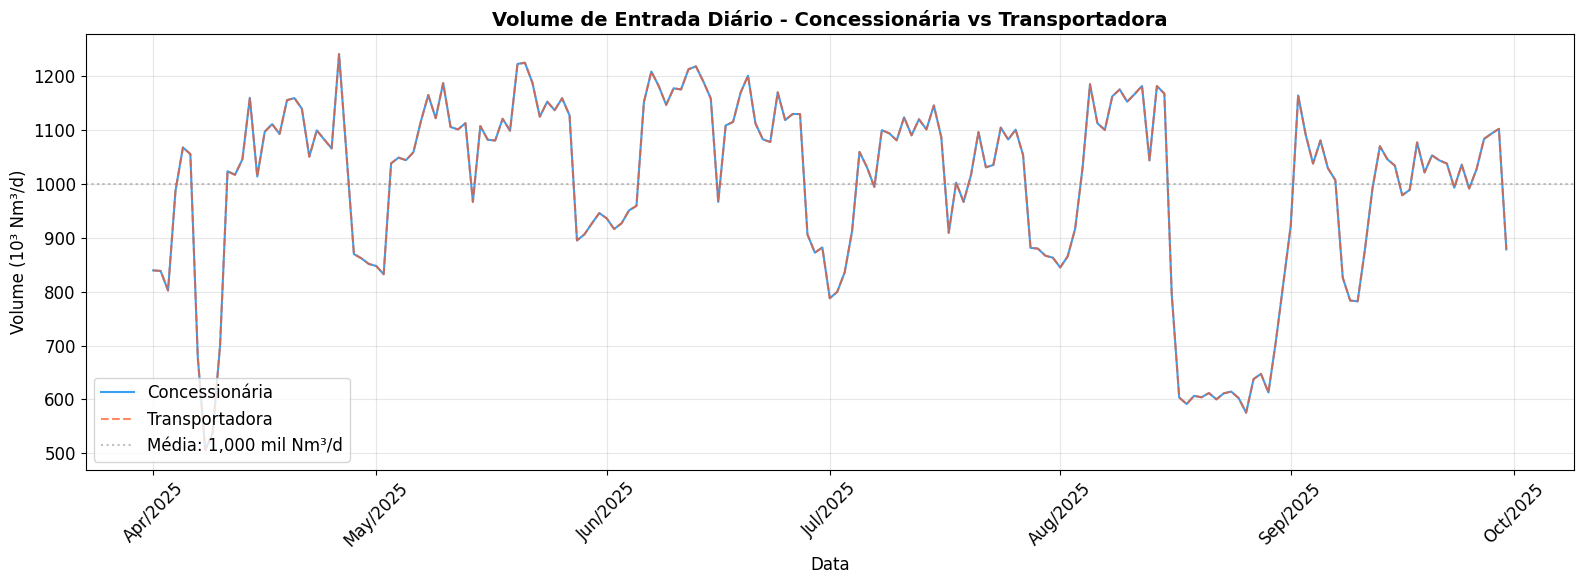

In [5]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df['Data'], df['Concessionaria_Nm3d'] / 1000, 
        label='Concessionária', color='#2196F3', linewidth=1.5, alpha=0.9)
ax.plot(df['Data'], df['Transportadora_Nm3d'] / 1000, 
        label='Transportadora', color='#FF5722', linewidth=1.5, alpha=0.7, linestyle='--')

# Linha de média
media = df['Concessionaria_Nm3d'].mean() / 1000
ax.axhline(y=media, color='gray', linestyle=':', alpha=0.5, label=f'Média: {media:,.0f} mil Nm³/d')

ax.set_title('Volume de Entrada Diário - Concessionária vs Transportadora', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Volume (10³ Nm³/d)')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'vol_entrada_serie.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Série Temporal das Diferenças

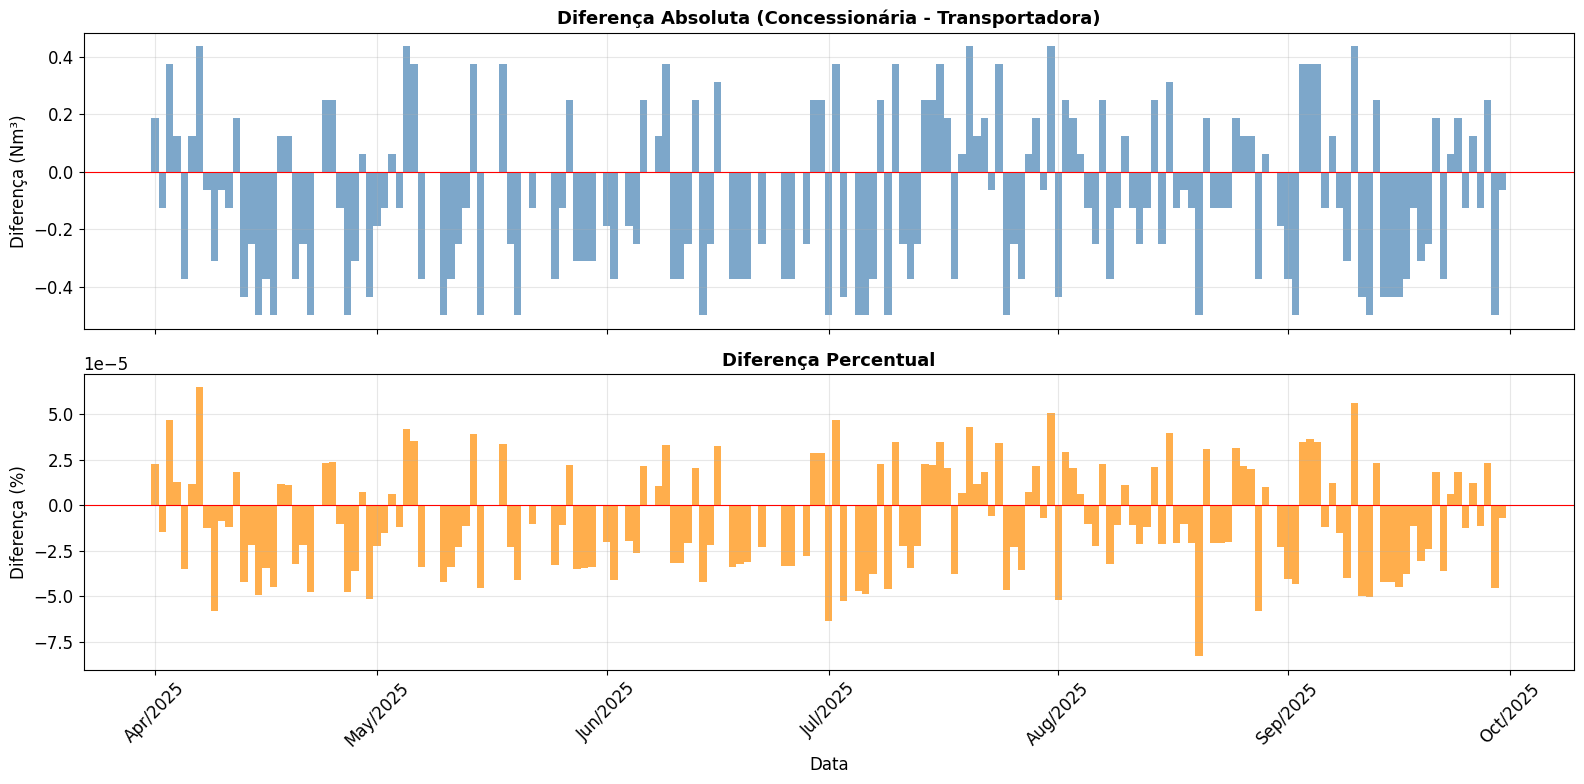

Diferença absoluta média: -0.0871 Nm³
Diferença percentual média: -0.000009%


In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Diferença absoluta
ax1.bar(df['Data'], df['Dif_Abs_Calc'], color='steelblue', alpha=0.7, width=1)
ax1.axhline(y=0, color='red', linewidth=0.8)
ax1.set_title('Diferença Absoluta (Concessionária - Transportadora)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Diferença (Nm³)')
ax1.grid(True, alpha=0.3)

# Diferença percentual
ax2.bar(df['Data'], df['Dif_Pct_Calc'], color='darkorange', alpha=0.7, width=1)
ax2.axhline(y=0, color='red', linewidth=0.8)
ax2.set_title('Diferença Percentual', fontsize=13, fontweight='bold')
ax2.set_ylabel('Diferença (%)')
ax2.set_xlabel('Data')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'vol_entrada_diferencas.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f'Diferença absoluta média: {df["Dif_Abs_Calc"].mean():.4f} Nm³')
print(f'Diferença percentual média: {df["Dif_Pct_Calc"].mean():.6f}%')

### 3.3 Histograma das Diferenças

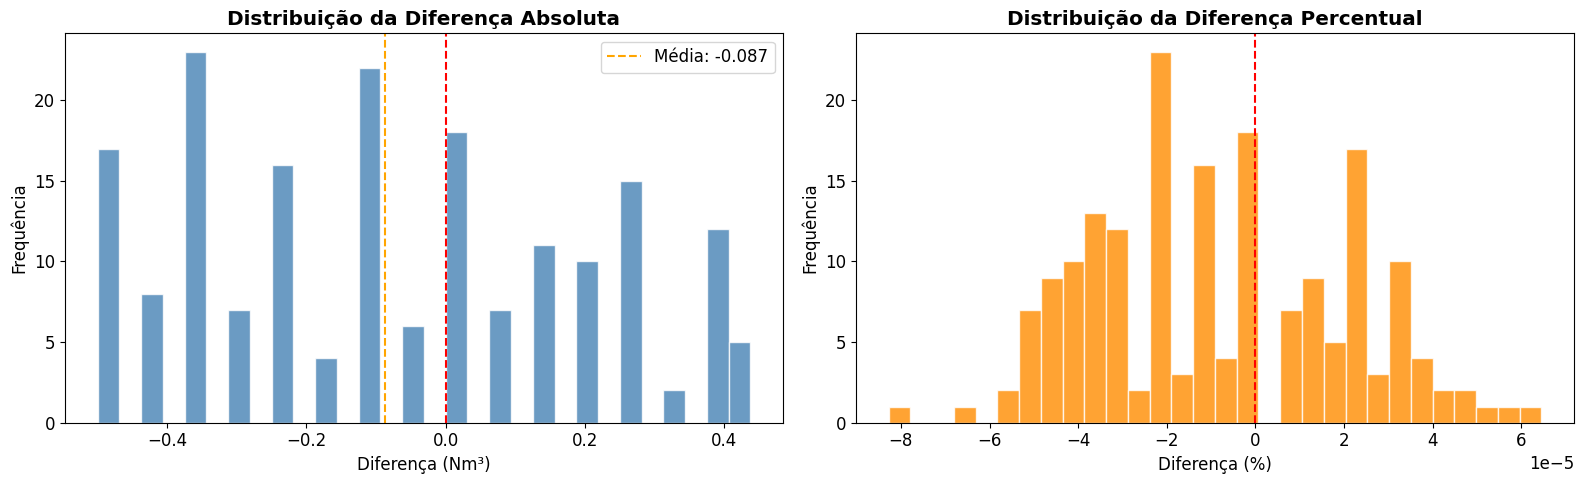

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Histograma da diferença absoluta
ax1.hist(df['Dif_Abs_Calc'], bins=30, color='steelblue', edgecolor='white', alpha=0.8)
ax1.axvline(x=0, color='red', linewidth=1.5, linestyle='--')
ax1.axvline(x=df['Dif_Abs_Calc'].mean(), color='orange', linewidth=1.5, 
            linestyle='--', label=f'Média: {df["Dif_Abs_Calc"].mean():.3f}')
ax1.set_title('Distribuição da Diferença Absoluta', fontweight='bold')
ax1.set_xlabel('Diferença (Nm³)')
ax1.set_ylabel('Frequência')
ax1.legend()

# Histograma da diferença percentual
ax2.hist(df['Dif_Pct_Calc'], bins=30, color='darkorange', edgecolor='white', alpha=0.8)
ax2.axvline(x=0, color='red', linewidth=1.5, linestyle='--')
ax2.set_title('Distribuição da Diferença Percentual', fontweight='bold')
ax2.set_xlabel('Diferença (%)')
ax2.set_ylabel('Frequência')

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'vol_entrada_histograma.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Boxplot Mensal de Volumes

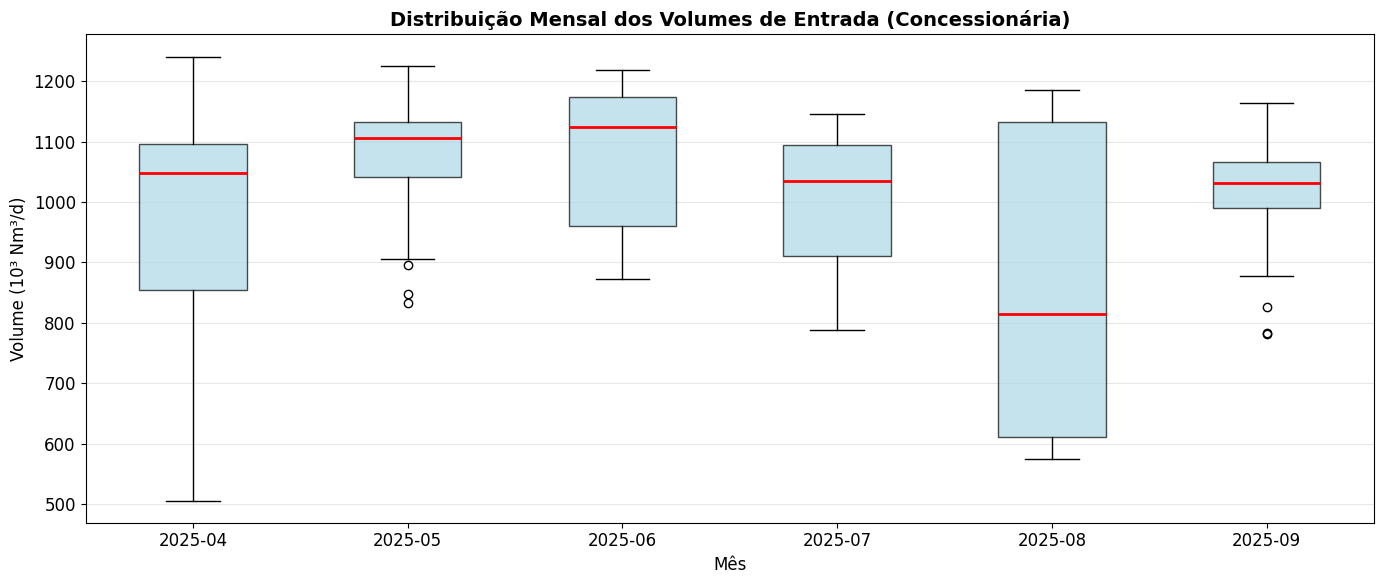

=== Volume Médio Mensal (Nm³/d) ===
                   mean          min          max            std
Mes                                                             
2025-04   973461.820833  505964.9375  1240864.875  185662.110295
2025-05  1072409.258065   832262.875    1224848.0  105769.864549
2025-06   1085016.35625    872264.25   1218171.25  114028.210842
2025-07   1008060.53629     787670.5   1145682.25  106684.022845
2025-08   855491.945565   575282.125  1184993.875  246074.319332
2025-09  1005023.027083  781997.4375    1164204.5   93429.127213


In [8]:
# Adicionar coluna de mês
df['Mes'] = df['Data'].dt.to_period('M').astype(str)

fig, ax = plt.subplots(figsize=(14, 6))

# Preparar dados para boxplot
meses_unicos = df['Mes'].unique()
dados_box = [df[df['Mes'] == m]['Concessionaria_Nm3d'].values / 1000 for m in meses_unicos]

bp = ax.boxplot(dados_box, labels=meses_unicos, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))

ax.set_title('Distribuição Mensal dos Volumes de Entrada (Concessionária)', fontsize=14, fontweight='bold')
ax.set_xlabel('Mês')
ax.set_ylabel('Volume (10³ Nm³/d)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'vol_entrada_boxplot.png'), dpi=150, bbox_inches='tight')
plt.show()

# Estatísticas mensais
print('=== Volume Médio Mensal (Nm³/d) ===')
print(df.groupby('Mes')['Concessionaria_Nm3d'].agg(['mean', 'min', 'max', 'std']).to_string())

## 4. Conclusões

### Observações:
- As medições de Concessionária e Transportadora são **praticamente idênticas** (diferença < 0,01%)
- O volume diário varia entre ~506 mil e ~1,24 milhão Nm³/d
- A média é de ~999,6 mil Nm³/d (~41.648 m³/h)
- A concordância entre as partes valida a transferência de custódia